In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import timeit
import sys, time

<h1>Load training, validation, testing set from your preprocessed files</h1>

In [11]:
def unpickle(fileName):
    with open(fileName, 'rb') as f:
        data = pickle.load(f)
    return data

In [3]:
train_image = []
train_labels = []

test_image = []

val_image = []
val_labels = []

for i in range(0,5):
    data = unpickle('/home/lkumari/data/dogs-vs-cats/new/q4_train_data_' + str(i))
    for j in range(len(data)):
        train_image.append(data[j][0])
        train_labels.append(data[j][1])
        
## loading only 10 test images because of memory limitations
## I had shuffled test data before saving, so my first 10 images might not be same as required
data = unpickle('/home/lkumari/data/dogs-vs-cats/q4_test_data')
for j in range(len(data[:10])):
    test_image.append(data[j][0])

data = unpickle('/home/lkumari/data/dogs-vs-cats/new/q4_val_data')
for j in range(len(data)):
    val_image.append(data[j][0])
    val_labels.append(data[j][1])
    
train_image = np.asarray(train_image)
train_image = train_image.reshape(-1, 227, 227, 3)


test_image = np.asarray(test_image)
test_image = test_image.reshape(-1, 227, 227, 3)

val_image = np.asarray(val_image)
val_image = val_image.reshape(-1, 227, 227, 3)

<h1>Define hyperparameter</h1>

In [12]:
EPOCH = 15
BATCH_SIZE = 128
lr = 0.0001
# keep_prob = 0.7

img_size = 227
num_channels = 3
num_classes = 2

In [19]:
tf.reset_default_graph()

<h1>Placeholder</h1>

In [20]:
X = tf.placeholder(tf.float32, [None, img_size, img_size, num_channels], name='X')
Y = tf.placeholder(tf.float32, [None, num_classes], name='Y')


def initialize_weights(name, shape):
    return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0, seed=None, uniform=False, mode='FAN_IN', dtype=tf.float32))

    
def initialize_bias(name, shape):
    return tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=shape), name=name)

<h1>AlexNet</h1>

In [21]:
def AlexNet(x):

    # CONV layer 1
    with tf.name_scope('conv_1') as scope:
        kernel = initialize_weights('W_conv1', [11,11,3,96])
        convolve = tf.nn.conv2d(x, kernel, [1,4,4,1], padding='SAME')
        biases = initialize_bias('b_conv1', [96])
        conv_1 = tf.nn.relu(tf.nn.bias_add(convolve, biases), name=scope)

    with tf.name_scope('batchnorm_1') as scope:
        mean, variance = tf.nn.moments(conv_1, [0,1,2])
        batchnorm_1 = tf.nn.batch_normalization(conv_1, mean, variance, 0, 1, 0, name=scope)

    with tf.name_scope('maxpool_1') as scope:
        maxpool_1 = tf.nn.max_pool(batchnorm_1, [1,3,3,1], [1,2,2,1], padding='SAME', name=scope)

    # CONV layer 2
    with tf.name_scope('conv_2') as scope:
        kernel = initialize_weights('W_conv2', [5,5,96,256])
        convolve = tf.nn.conv2d(maxpool_1, kernel, [1,1,1,1], padding='SAME')
        biases = initialize_bias('b_conv2', [256])
        conv_2 = tf.nn.relu(tf.nn.bias_add(convolve, biases), name=scope)

    with tf.name_scope('batchnorm_2') as scope:
        mean, variance = tf.nn.moments(conv_2, [0,1,2])
        batchnorm_2 = tf.nn.batch_normalization(conv_2, mean, variance, 0, 1, 0, name=scope)

    with tf.name_scope('maxpool_2') as scope:
        maxpool_2 = tf.nn.max_pool(batchnorm_2, [1,3,3,1], [1,2,2,1], padding='SAME', name=scope)

    # CONV layer 3
    with tf.name_scope('conv_3') as scope:
        kernel = initialize_weights('W_conv3', [3,3,256,384])
        convolve = tf.nn.conv2d(maxpool_2, kernel, [1,1,1,1], padding='SAME')
        biases = initialize_bias('b_conv3', [384])
        conv_3 = tf.nn.relu(tf.nn.bias_add(convolve, biases), name=scope)

    with tf.name_scope('batchnorm_3') as scope:
        mean, variance = tf.nn.moments(conv_3, [0,1,2])
        batchnorm_3 = tf.nn.batch_normalization(conv_3, mean, variance, 0, 1, 0, name=scope)

    # CONV layer 4
    with tf.name_scope('conv_4') as scope:
        kernel = initialize_weights('W_conv4', [3,3,384,384])
        convolve = tf.nn.conv2d(batchnorm_3, kernel, [1,1,1,1], padding='SAME')
        biases = initialize_bias('b_conv4', [384])
        conv_4 = tf.nn.relu(tf.nn.bias_add(convolve, biases), name=scope)

    with tf.name_scope('batchnorm_4') as scope:
        mean, variance = tf.nn.moments(conv_4, [0,1,2])
        batchnorm_4 = tf.nn.batch_normalization(conv_4, mean, variance, 0, 1, 0, name=scope)

    # CONV layer 5
    with tf.name_scope('conv_5') as scope:
        kernel = initialize_weights('W_conv5', [3,3,384,256])
        convolve = tf.nn.conv2d(batchnorm_4, kernel, [1,1,1,1], padding='SAME')
        biases = initialize_bias('b_conv5', [256])
        conv_5 = tf.nn.relu(tf.nn.bias_add(convolve, biases), name=scope)

    with tf.name_scope('batchnorm_5') as scope:
        mean, variance = tf.nn.moments(conv_5, [0,1,2])
        batchnorm_5 = tf.nn.batch_normalization(conv_5, mean, variance, 0, 1, 0, name=scope)

    with tf.name_scope('maxpool_5') as scope:
        maxpool_5 = tf.nn.max_pool(batchnorm_5, [1,3,3,1], [1,2,2,1], padding='VALID', name=scope)

    # FC layer 6
    with tf.name_scope('fc_6') as scope:
        flatten = tf.contrib.layers.flatten(maxpool_5)
        fc_6 = tf.layers.dense(flatten, units=4096, activation=tf.nn.relu, name=scope)
        dropout_6 = tf.layers.dropout(fc_6, 0.0)

    # FC layer 7
    with tf.name_scope('fc_7') as scope:
        fc_7 = tf.layers.dense(dropout_6, units=4096, activation=tf.nn.relu, name=scope)
        dropout_7 = tf.layers.dropout(fc_7, 0.0)

    # FC layer 8
    with tf.name_scope('output') as scope:
        outputs = tf.layers.dense(dropout_7, units=num_classes, name=scope)

    return outputs

<h1>Cost and Optimization</h1>

In [22]:
#predicted labels
logits = AlexNet(X)

#define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y),name='loss')

#define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

#Initialize the variables
g_init = tf.global_variables_initializer()

In [23]:
len(train_image)

24500

<h1>Training and validation</h1>
<h2>Train your model only 10 epochs</h2>
<p style="font-size:20px">1. Print out training accuracy and validation accuracy each training epoch</p>
<p style="font-size:20px">2. Print out training time each training epoch</p>
<p style="font-size:20px">3. Your goal is to reach 85% validation accuracy in 10 training epochs. If you reach that, you can perform testing, print out your test accuracy. Plot out the ten images with title that contains the probability of the labeled class.</p>

In [24]:
train_accuracy = []
val_accuracy = []
time_taken = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(g_init)
    for ep in range(EPOCH):
        start_time = time.time()
        for i in range(0, len(train_image), BATCH_SIZE):
            train_loss, acc, _ = sess.run(fetches=[loss, accuracy, train_op],
                                   feed_dict={X: train_image[i:BATCH_SIZE+i], Y: train_labels[i:BATCH_SIZE+i]})
        
        end_time = time.time()
        time_s = end_time - start_time
        
        val_acc = sess.run([accuracy], feed_dict={X:val_image, Y: val_labels})
        time_taken.append(time_s)
        val_accuracy.append(val_acc[0])
        train_accuracy.append(acc)
        
        print("Epoch {}: training loss = {}, training_time = {}, train_accuracy = {}, val_accuracy = {}".format(
        ep, train_loss, time_s, acc, val_acc[0]))
        
    preds = sess.run([tf.nn.softmax(logits)], feed_dict={X:test_image})
    preds = np.asarray(preds).reshape(test_image.shape[0], num_classes)

Epoch 0: training loss = 0.49123919010162354, training_time = 98.21298885345459, train_accuracy = 0.7884615659713745, val_accuracy = 0.6800000071525574
Epoch 1: training loss = 0.33350175619125366, training_time = 97.60384368896484, train_accuracy = 0.8269230723381042, val_accuracy = 0.8080000281333923
Epoch 2: training loss = 0.1824069321155548, training_time = 97.98536038398743, train_accuracy = 0.942307710647583, val_accuracy = 0.8199999928474426
Epoch 3: training loss = 0.09244252741336823, training_time = 97.6335551738739, train_accuracy = 1.0, val_accuracy = 0.8199999928474426
Epoch 4: training loss = 0.1011289432644844, training_time = 97.89266204833984, train_accuracy = 0.9615384340286255, val_accuracy = 0.8140000104904175
Epoch 5: training loss = 0.05607149749994278, training_time = 97.83990359306335, train_accuracy = 0.9807692170143127, val_accuracy = 0.8259999752044678
Epoch 6: training loss = 0.04506102576851845, training_time = 97.56495356559753, train_accuracy = 1.0, val_

[[1.6909338e-06 9.9999833e-01]
 [2.4595269e-04 9.9975401e-01]
 [6.3513167e-04 9.9936491e-01]
 [9.4356096e-01 5.6439009e-02]
 [4.9096637e-04 9.9950898e-01]
 [9.6122062e-01 3.8779374e-02]
 [9.0788150e-01 9.2118487e-02]
 [3.4367969e-07 9.9999964e-01]
 [2.3094125e-07 9.9999976e-01]
 [9.9999571e-01 4.2409865e-06]]


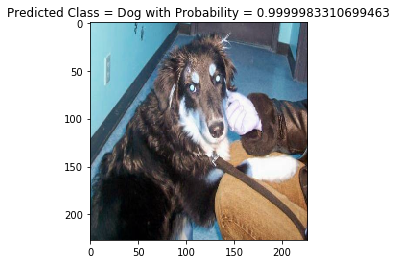

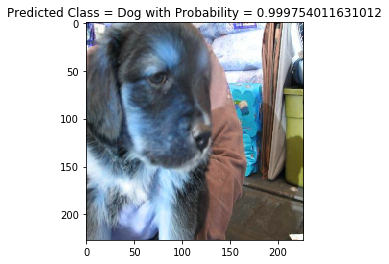

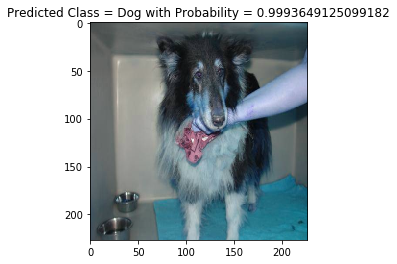

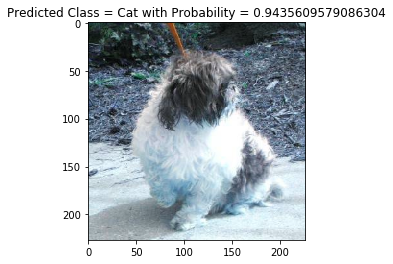

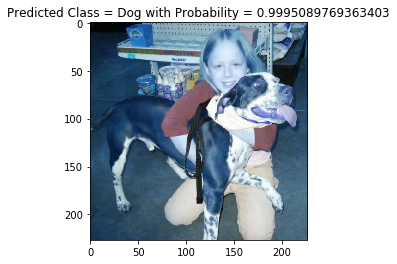

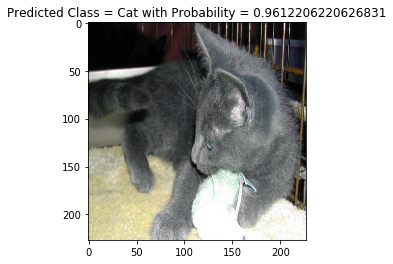

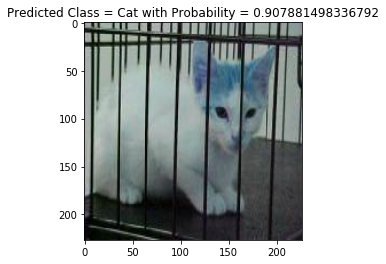

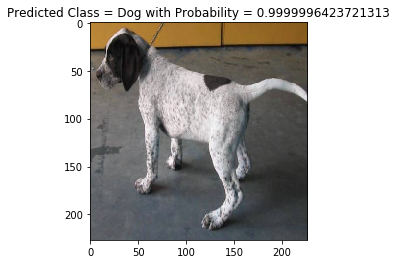

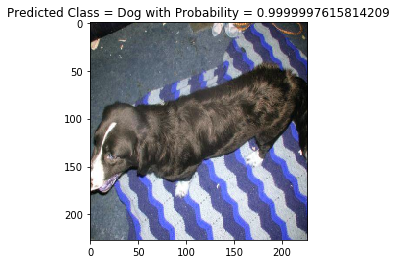

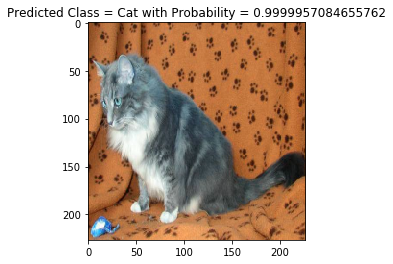

In [25]:
print (preds)
for i in range(preds.shape[0]):
    pred_class = np.argmax(preds[i])
    if pred_class == 0:
        label = 'Cat'
    else:
        label = 'Dog'
    plt.figure()
    plt.imshow(test_image[i])
    plt.title("Predicted Class = {} with Probability = {}".format(label, preds[i][pred_class]))

<h2> predictions for 9 (out of 10) images are correct except for the 4th image </h2> 